In [1]:
import skvideo as vi
import skvideo.io
import skvideo.motion
import skvideo.measure
import skvideo.datasets
raw_carphone = vi.io.vread("carphone_qcif.y4m",as_grey=False)
raw_suzie = vi.io.vread("suzie_qcif.y4m",as_grey=False)

print(raw_suzie.shape)

(150, 144, 176, 3)


In [2]:
method = "SE3SS"
M_blocks = [4,8,16]


In [2]:
import numpy as np


def compressor(ref , mb , out_name , method = "SE3SS"):
    motion = vi.motion.blockMotion(ref , method ,mbSize=mb )
    compensate = vi.motion.blockComp(ref , motion ,mbSize=mb)
    diff = ref - compensate
    vi.io.vwrite(out_name , compensate)
    return compensate


def quality_assessment(ref , comp):
    mse = np.median(skvideo.measure.mse(ref[:,:,:,1] , comp[:,:,:,1]))
    psnr = np.median(skvideo.measure.psnr(ref[:,:,:,1] , comp[:,:,:,1]))
    ssim = np.median(skvideo.measure.ssim(ref[:,:,:,1] , comp[:,:,:,1]))

    return mse , psnr , ssim

In [4]:
car_qualities = []
for b in M_blocks:
    comp = compressor(raw_carphone , b , "car"+str(b)+".mp4")
    tmp = quality_assessment(raw_carphone , comp)
    car_qualities.append(tmp)

c:\Users\Farhad\anaconda3\envs\gputest\lib\site-packages\skvideo\measure\psnr.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  psnr = 10 * np.log10(maxsq / mse)


In [5]:
suzie_qualities = []
for b in M_blocks:
    comp = compressor(raw_suzie , b , "suzie"+str(b)+".mp4")
    tmp = quality_assessment(raw_suzie , comp)
    suzie_qualities.append(tmp)



In [6]:

car_qualities = np.array(car_qualities)
suzie_qualities = np.array(suzie_qualities)

In [7]:
car_qualities

array([[1.14531262e+03, 1.75415632e+01, 8.81164670e-01],
       [2.15171558e+03, 1.48029550e+01, 8.48773360e-01],
       [4.19437402e+03, 1.19041324e+01, 7.71484494e-01]])

In [8]:
suzie_qualities

array([[8.27428528e+02, 1.89534989e+01, 9.00173008e-01],
       [1.51879321e+03, 1.63158193e+01, 8.65517378e-01],
       [2.82153857e+03, 1.36259440e+01, 7.80767143e-01]])

## part 2:

In [9]:
import timeit

methods = [ "DS", "ES" , "3SS" , "N3SS" , "SE3SS"   ]

SSIMs = []
TIMEs = []


for m in methods:
    start = timeit.default_timer()
    comp = compressor(raw_suzie , mb=8 , out_name = m + ".mp4" , method = m)
    stop = timeit.default_timer()
    SSIMs.append(quality_assessment(raw_suzie , comp)[2])
    TIMEs.append( stop - start)
    print("**" , stop - start)

** 18.12318520000008
** 30.843062999999802
** 19.922163599999976
** 32.60986500000013
** 9.260458899999776


In [14]:
SSIMs

[0.82710284, 0.86047816, 0.8628992, 0.91876304, 0.8655174]

In [15]:
TIMEs

[18.12318520000008,
 30.843062999999802,
 19.922163599999976,
 32.60986500000013,
 9.260458899999776]

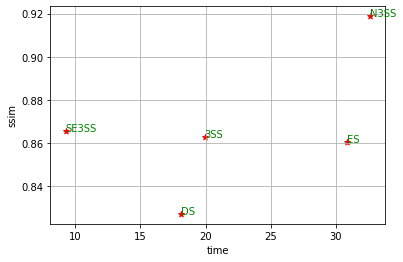

In [13]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.scatter(TIMEs, SSIMs, color="red" , marker="*")

plt.grid()

plt.xlabel("time")
plt.ylabel("ssim")

for i, txt in enumerate(methods):
    ax.annotate(txt, (TIMEs[i], SSIMs[i]),color="green")

## part 3:

In [2]:
import skvideo.io
import skvideo.motion
import skvideo.datasets

raw_suzie = skvideo.io.vread("suzie_qcif.y4m",as_grey=False)

motion = skvideo.motion.blockMotion(raw_suzie)

print(raw_suzie.shape)
print(motion.shape)

(150, 144, 176, 3)
(149, 18, 22, 2)


In [6]:
motion[7,5,18]

array([0, 0], dtype=int8)

In [7]:
compmotion = skvideo.motion.blockComp(raw_suzie, motion)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
from PIL import Image

import skvideo.datasets
from skimage.transform import resize
from skimage import data


try:
    xrange
except NameError:
    xrange = range

def getPlots(motionData):
    motionMagnitude = np.sqrt(np.sum(motionData**2, axis=2))

    fig = plt.figure()
    plt.quiver(motionData[::-1, :, 0], motionData[::-1, :, 1])
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.tight_layout()
    fig.canvas.draw()
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (h, w, 4)
    quiver = buf[:, :, 1:]
    plt.close()

    fig = plt.figure()
    plt.imshow(motionMagnitude, cmap="Greys_r")
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.tight_layout()
    fig.canvas.draw()

    w,h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (h, w, 4)
    magnitude = buf[:, :, 1:]
    plt.close()

    # histogram it
    fig = plt.figure()
    hist, bins = np.histogram(motionMagnitude, bins=10, range=(-0.5, 9.5))
    center = (bins[1:] + bins[:-1])/2.0
    plt.scatter(center, hist)
    plt.xlabel("Motion magnitude")
    plt.ylabel("Count")
    plt.ylim([0, 14000])
    plt.grid()
    plt.tight_layout()
    fig.canvas.draw()

    w,h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (h, w, 4)
    histogram = buf[:, :, 1:]
    plt.close()

    return quiver, magnitude, histogram


filename = "suzie_qcif.y4m"
videodata = skvideo.io.vread("suzie_qcif.y4m",as_grey=False)


videometadata = skvideo.io.ffprobe(filename)
frame_rate = videometadata['video']['@avg_frame_rate']

T, M, N, C = videodata.shape

motionData = skvideo.motion.blockMotion(videodata)

writer = skvideo.io.FFmpegWriter("motion.mp4", inputdict={
    "-r": frame_rate
})

for i in xrange(T-1):
    a, b, c = getPlots(motionData[i])
    # frame = scipy.misc.imresize(videodata[i+1], (a.shape[0], a.shape[1], 3))

    frame =  resize(videodata[i+1], (a.shape[0], a.shape[1], 3))

    outputframe = np.zeros((frame.shape[0]*2, frame.shape[1]*2, 3), dtype=np.uint8)

    outputframe[:frame.shape[0], :frame.shape[1]] = frame
    outputframe[frame.shape[0]:, :frame.shape[1]] = a
    outputframe[:frame.shape[0], frame.shape[1]:] = b
    outputframe[frame.shape[0]:, frame.shape[1]:] = c

    writer.writeFrame(outputframe)

writer.close()